<a href="https://colab.research.google.com/github/JohnPoma/projet/blob/master/ameliorationeffXception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: code pour monter drive dans colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prompt: afficher le nombre de images par classe dans le repertoire de train

#from google.colab import drive
import os
import shutil
import random

#drive.mount('/content/drive')


# Replace with the actual path to your dataset directory in Google Drive
train_dataset_path = '/content/drive/My Drive/Deeplearning/lung_image_sets_split/train'

if os.path.exists(train_dataset_path):
  class_counts = {}
  for root, _, files in os.walk(train_dataset_path):
    for file in files:
      class_name = os.path.basename(root)  # Assuming class is represented by directory name
      if class_name not in class_counts:
        class_counts[class_name] = 0
      class_counts[class_name] += 1


  print("\nNumber of data points per class in train directory:")
  for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

else:
  print(f"Dataset directory '{train_dataset_path}' not found.")


Number of data points per class in train directory:
- lung_n: 3500
- lung_aca: 3500
- lung_scc: 3500


In [3]:
# prompt: afficher le nombre de données par classe du repertoire de test et validation

# Replace with the actual path to your dataset directory in Google Drive
test_dataset_path = '/content/drive/My Drive/Deeplearning/lung_image_sets_split/test'
val_dataset_path = '/content/drive/My Drive/Deeplearning/lung_image_sets_split/val'


if os.path.exists(test_dataset_path):
  class_counts = {}
  for root, _, files in os.walk(test_dataset_path):
    for file in files:
      class_name = os.path.basename(root)  # Assuming class is represented by directory name
      if class_name not in class_counts:
        class_counts[class_name] = 0
      class_counts[class_name] += 1


  print("\nNumber of data points per class in test directory:")
  for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

else:
  print(f"Dataset directory '{test_dataset_path}' not found.")

if os.path.exists(val_dataset_path):
  class_counts = {}
  for root, _, files in os.walk(val_dataset_path):
    for file in files:
      class_name = os.path.basename(root)  # Assuming class is represented by directory name
      if class_name not in class_counts:
        class_counts[class_name] = 0
      class_counts[class_name] += 1


  print("\nNumber of data points per class in validation directory:")
  for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

else:
  print(f"Dataset directory '{val_dataset_path}' not found.")


Number of data points per class in test directory:
- lung_n: 750
- lung_aca: 750
- lung_scc: 750

Number of data points per class in validation directory:
- lung_n: 750
- lung_aca: 750
- lung_scc: 750


In [4]:
# prompt: applique la data augmentation sur les données d'entrainement

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemin vers le répertoire contenant les données d'entraînement
train_data_dir = '/content/drive/My Drive/Deeplearning/lung_image_sets_split/train'

# Créer un générateur d'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Appliquer l'augmentation de données sur les données d'entraînement
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # You might want to apply the same preprocessing as training data

val_generator = val_datagen.flow_from_directory(
    val_dataset_path,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size if needed
    shuffle=False,
    class_mode='categorical'
)
test_datagen = ImageDataGenerator(rescale=1./255)  # You might want to apply the same preprocessing as training data

test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size if needed,
    shuffle=False,
    class_mode='categorical'
)

Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.


In [5]:
from ast import mod
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import concatenate, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers

# Chargement des modèles pré-entraînés sans la couche de classification
input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

efficientnet_b0_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
xception_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
mobilenet_v2_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Fine-tuning partiel : dégeler certaines couches
#for layer in efficientnet_b0_model.layers[-30:]:
    #layer.trainable = True
#for layer in xception_model.layers[-30:]:
    #layer.trainable = True

# Geler les poids des modèles EfficientNetB0 et Xception
for layer in efficientnet_b0_model.layers:
    layer.trainable = False
for layer in xception_model.layers:
    layer.trainable = False
for layer in mobilenet_v2_model.layers:
    layer.trainable = False

# Extraction des features
efficientnet_features = efficientnet_b0_model.output
xception_features = xception_model.output
mobilenet_v2_features = mobilenet_v2_model.output

# Fusion des features
merged_features = concatenate([efficientnet_features, xception_features,mobilenet_v2_features])

# Ajout des couches de classification
x = GlobalAveragePooling2D()(merged_features)
x = Dense(1024, activation='relu')(x) # Normalisation après la couche dense
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Dense(64, activation='relu')(x)
#x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x)  # 3 classes

# Création du modèle hybride
hybrid_model = Model(inputs=input_tensor, outputs=output_layer)

# Compilation
optimizer = Adam(learning_rate=0.00005)
hybrid_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks avec ajustement dynamique du learning rate
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]



83683744/83683744 [==============================] - 0s 0us/step


9406464/9406464 [==============================] - 0s 0us/step


In [7]:
# Entraînement
history = hybrid_model.fit(
    train_generator,
    epochs=10,  # Augmentez si les résultats s'améliorent 20
    batch_size=32,#64
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 5026s 15s/step - accuracy: 0.6109 - loss: 0.8817 - val_accuracy: 0.9382 - val_loss: 0.1803 - learning_rate: 5.0000e-05
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 739s 2s/step - accuracy: 0.8747 - loss: 0.3064 - val_accuracy: 0.9418 - val_loss: 0.1644 - learning_rate: 5.0000e-05
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9100 - loss: 0.2350 - val_accuracy: 0.9471 - val_loss: 0.1356 - learning_rate: 5.0000e-05
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.9149 - loss: 0.2201 - val_accuracy: 0.9498 - val_loss: 0.1272 - learning_rate: 5.0000e-05
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 761s 2s/step - accuracy: 0.9301 - loss: 0.1805 - val_accuracy: 0.9342 - val_loss: 0.1706 - learning_rate: 5.0000e-05
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 813s 2s/step - accuracy: 0.9413 - loss: 0.1550 - val_accuracy: 0.9564 - val_loss: 0.1167 - learning_rate: 5.0000e-05
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 935s 3s/step - accuracy: 0.

In [11]:
# prompt: sauvegarder le modele
import os  # Import os module for file operations

# Specify the path where you want to save the model
model_save_path = '/content/drive/My Drive/Deeplearning/saved_model/my_model.keras'  # Added .keras extension

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # Create parent directories if needed

# Save the model
hybrid_model.save(model_save_path)

print(f"Model saved to: {model_save_path}")# prompt: sauvegarder le modele
import os  # Import os module for file operations

# Specify the path where you want to save the model
model_save_path = '/content/drive/My Drive/Deeplearning/saved_model/my_model.keras'  # Added .keras extension

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # Create parent directories if needed

# Save the model
hybrid_model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/My Drive/Deeplearning/saved_model/my_model.keras
Model saved to: /content/drive/My Drive/Deeplearning/saved_model/my_model.keras


In [9]:
# prompt: test accuracy

# Evaluate the model on the test data
loss, accuracy = hybrid_model.evaluate(test_generator)

print('Test accuracy:', accuracy)
print('Test loss:', loss)

71/71 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9476 - loss: 0.1320
Test accuracy: 0.9679999947547913
Test loss: 0.09307046234607697


In [12]:
# prompt: print for validation data the accuracy and loss

# ... (Your existing code) ...

# Evaluate the model on the validation data
val_loss, val_accuracy = hybrid_model.evaluate(val_generator)

print('Validation accuracy:', val_accuracy)
print('Validation loss:', val_loss)

# Evaluate the model on the test data
loss, accuracy = hybrid_model.evaluate(test_generator)

print('Test accuracy:', accuracy)
print('Test loss:', loss)
#accuracy for train
loss, accuracy = hybrid_model.evaluate(train_generator)

print('Train accuracy:', accuracy)
print('Train loss:', loss)

71/71 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9393 - loss: 0.1375
Validation accuracy: 0.9613333344459534
Validation loss: 0.10037233680486679
71/71 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9476 - loss: 0.1320
Test accuracy: 0.9679999947547913
Test loss: 0.09307046234607697
329/329 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - accuracy: 0.9589 - loss: 0.0960
Train accuracy: 0.9545714259147644
Train loss: 0.1087988018989563


71/71 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step
              precision    recall  f1-score   support

    lung_aca       0.98      0.92      0.95       750
      lung_n       1.00      1.00      1.00       750
    lung_scc       0.93      0.98      0.95       750

    accuracy                           0.97      2250
   macro avg       0.97      0.97      0.97      2250
weighted avg       0.97      0.97      0.97      2250



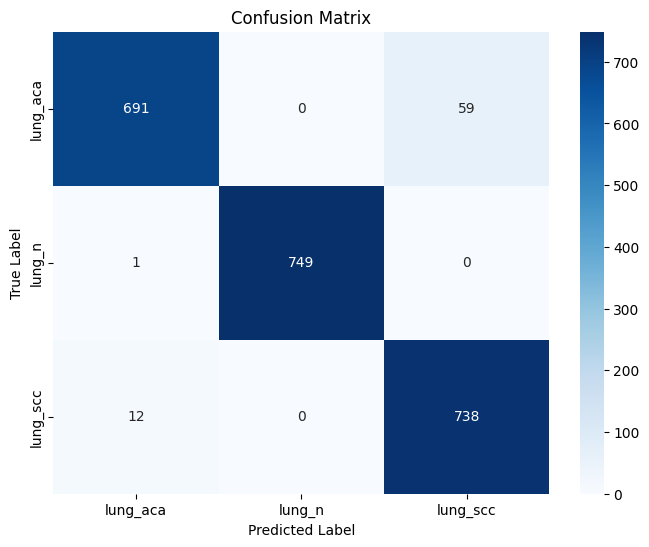

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions for the test data
Y_pred = hybrid_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels for the test data
y_true = test_generator.classes  # Assign the true labels to y_true

# Get class names from the generator
class_names = list(test_generator.class_indices.keys()) # Assuming test_generator has class_indices

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# You can also visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

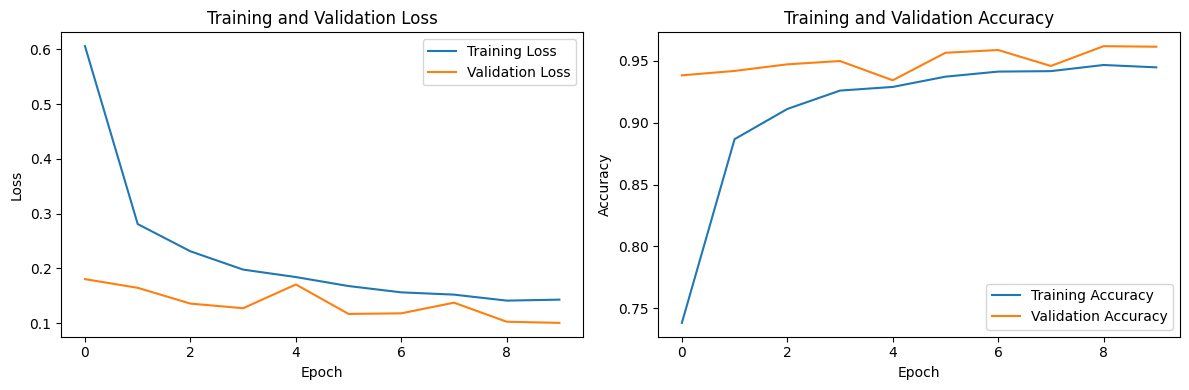

In [14]:
# prompt: affiche la courbe de validation et de perte

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

71/71 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step


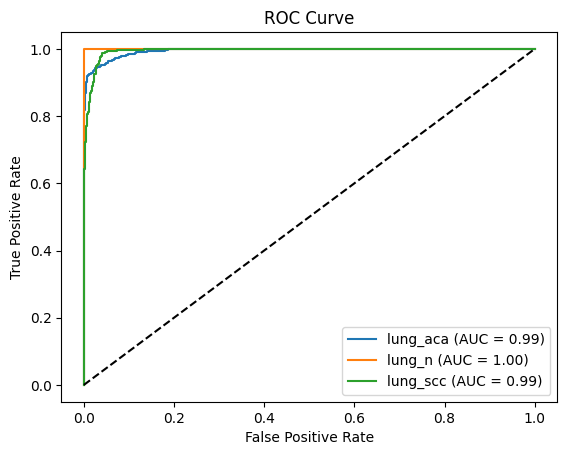

In [15]:
# prompt: ROC AUC

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for each class
Y_pred_proba = hybrid_model.predict(test_generator)

# Assuming you have 3 classes (e.g., 'normal', 'pneumonia', 'COVID-19')
# You can adjust the number of classes and labels accordingly
n_classes = 3
class_labels = list(test_generator.class_indices.keys())

# Calculate ROC AUC for each class
for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(test_generator.classes == i, Y_pred_proba[:, i])
    auc = roc_auc_score(test_generator.classes == i, Y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [16]:
# prompt: calculer la sensitivité et la précision du modèle

from sklearn.metrics import confusion_matrix

# Assuming you have y_true and y_pred from your model's evaluation

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Extract true positive (TP), true negative (TN), false positive (FP), false negative (FN)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

# Calculate sensitivity (recall)
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

# Calculate precision
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Precision: {precision:.4f}")

Sensitivity: 0.9987
Precision: 1.0000
